<a href="https://colab.research.google.com/github/GrueneKatze/GANs/blob/main/Face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TF Progressive GAN Model with Celeba

In [ ]:
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-278hvqz8
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-278hvqz8
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0304a7e4a90e53751ac59cab46667d78e81736fa3_-py3-none-any.whl size=154235 sha256=44f71a13ac6343d2fb1132c81315cf06e84e0df6fbf43ff5efbb5df8cbd7fdd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6t7dozvq/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

In [ ]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

In [ ]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Creates a tensor with 200 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 200)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
#animate(interpolated_images)

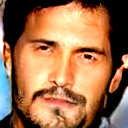

In [ ]:
display_image(interpolated_images[180])

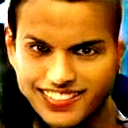

In [ ]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

In [ ]:
#tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

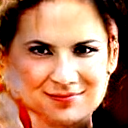

In [ ]:
display_image(progan(initial_vector)['default'][0])

In [ ]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=100
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................

(0.0, 5325.40034790039)

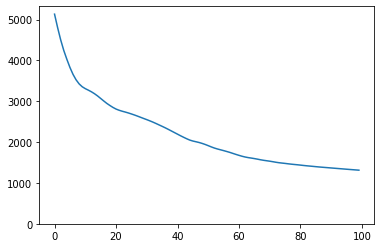

In [ ]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])

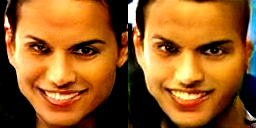

In [ ]:
display_image(np.concatenate([images[-1], target_image], axis=1))

##Simple GAN with Celeba

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/Celeba/img_align_celeba.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/gdrive/MyDrive/Celeba/cel')

In [2]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
import shutil

In [3]:
about = pd.read_csv('/content/gdrive/MyDrive/Celeba/list_attr_celeba.csv')
about[:10]

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [5]:
about.columns, about.shape

(Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
        'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
        'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
        'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
        'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
        'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
        'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
        'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
        'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
        'Wearing_Necktie', 'Young'],
       dtype='object'), (202599, 41))

In [4]:
fblackh = about[(about['Male']==-1)&(about['Black_Hair']==1)]
fblackh.shape

(23316, 41)

In [8]:
fblackh.sample(3)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
80128,080129.jpg,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1
175808,175809.jpg,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,-1,1
24845,024846.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1


In [8]:
os.path.isfile('/content/gdrive/MyDrive/Celeba/cel/femblackh/175809.jpg')

False

In [5]:
l = ['080129.jpg', '175809.jpg']
for i in l:
  shutil.move('/content/gdrive/MyDrive/Celeba/cel/img_align_celeba/'+i, '/content/gdrive/MyDrive/Celeba/femblackh')

FileNotFoundError: ignored

In [ ]:
#4

100%|██████████| 10000/10000 [44:19<00:00,  3.76it/s]


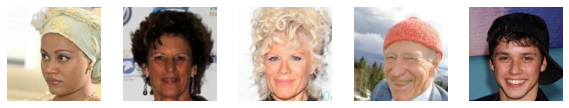

In [ ]:

#

PIC_DIR = '/content/gdrive/MyDrive/Celeba/cel/img_align_celeba/'
#r'C:\Users\Tanya\Desktop\img_align_celeba'#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba'
#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba'#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
#https://github.com/nageshsinghc4/Face-generation-GAN/blob/master/face_GAN.ipynb
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator


In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
import time
iters = 20000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('Epochs')
plt.ylabel('Discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('Epochs')
plt.ylabel('Adversary losses')
plt.show()

50/20000: d_loss: 0.5941,  a_loss: 0.6583.  (2.1 sec)
100/20000: d_loss: 0.6410,  a_loss: 0.9925.  (2.1 sec)
150/20000: d_loss: 0.6371,  a_loss: 1.1850.  (2.1 sec)
200/20000: d_loss: 0.6918,  a_loss: 0.9125.  (2.1 sec)
250/20000: d_loss: 0.6639,  a_loss: 0.8340.  (2.3 sec)
300/20000: d_loss: 0.7085,  a_loss: 0.9613.  (2.1 sec)
350/20000: d_loss: 0.6514,  a_loss: 0.9717.  (2.3 sec)
400/20000: d_loss: 0.6279,  a_loss: 0.8404.  (2.1 sec)
450/20000: d_loss: 0.7199,  a_loss: 1.0797.  (2.1 sec)
500/20000: d_loss: 0.5959,  a_loss: 0.9533.  (2.0 sec)
550/20000: d_loss: 0.6660,  a_loss: 1.0960.  (2.1 sec)
600/20000: d_loss: 0.6903,  a_loss: 0.7994.  (2.1 sec)
650/20000: d_loss: 0.6684,  a_loss: 0.9260.  (2.1 sec)
700/20000: d_loss: 0.6618,  a_loss: 0.9194.  (2.1 sec)
750/20000: d_loss: 0.5878,  a_loss: 0.8931.  (2.1 sec)
800/20000: d_loss: 0.6678,  a_loss: 1.0603.  (2.1 sec)
850/20000: d_loss: 0.6800,  a_loss: 1.1462.  (2.1 sec)
900/20000: d_loss: 0.6780,  a_loss: 1.2254.  (2.1 sec)
950/20000: 

In [ ]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)